This is an attempt to recreate the parameter estimation [example](https://sites.engineering.ucsb.edu/~jbraw/chemreacfun/fig-html/appendix/fig-A-10.html) from James Rawlings book on [Reactor Design](https://sites.engineering.ucsb.edu/~jbraw/chemreacfun/) using Pyomo.

In [21]:
# Import libraries
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyomo.environ as pyo
import pyomo.dae as dae
import scipy.stats as spstat

from pyomo.contrib.pynumero.interfaces.pyomo_nlp import PyomoNLP
from pyomo.contrib.pynumero.sparse import BlockSymMatrix, BlockMatrix, BlockVector
from scipy.sparse import identity
from scipy.sparse.linalg import spsolve

import get_redHessian as hess

This example has a series reaction $A \rightarrow B \rightarrow C$. The dataset consists of measures concentrations of A, B and C over time. The goal is to estimate the rate constants $k_1$ and $k_2$ for the two reactions.

In [2]:
data_df = pd.read_csv("ABC_data.csv")
data_df.head()

,t,ca,cb,cc
0,0.000,0.957,-0.031,-0.015
1,0.263,0.557,0.330,0.044
2,0.526,0.342,0.512,0.156
3,0.789,0.224,0.499,0.310
4,1.053,0.123,0.428,0.454


In [3]:
# Convert data to a list of dictionaries
data = [{'ca_meas': {k:v for (k, v) in zip(data_df.t, data_df.ca)},
    'cb_meas': {k:v for (k, v) in zip(data_df.t, data_df.cb)},
    'cc_meas': {k:v for (k, v) in zip(data_df.t, data_df.cc)} }]

In [4]:
#
# Define the model 
#
def ABC_model(data, disctype):
    
    ca_meas = data['ca_meas']
    cb_meas = data['cb_meas']
    cc_meas = data['cc_meas']
    
    meas_t = list(ca_meas.keys())
       
    ca0 = 1.0
    cb0 = 0.0
    cc0 = 0.0
        
    m = pyo.ConcreteModel()
    
    m.k1 = pyo.Var(initialize = 0.5, bounds = (1e-4, 10))
    m.k2 = pyo.Var(initialize = 3.0, bounds = (1e-4, 10))
    
    m.time = dae.ContinuousSet(bounds = (0.0, 5.0), initialize = meas_t)
    m.ca = pyo.Var(m.time, initialize = ca0, bounds = (0, ca0))
    m.cb = pyo.Var(m.time, initialize = cb0, bounds = (0, ca0))
    m.cc = pyo.Var(m.time, initialize = cc0, bounds = (0, ca0))
    
    m.dca = dae.DerivativeVar(m.ca, wrt = m.time)
    m.dcb = dae.DerivativeVar(m.cb, wrt = m.time)
    m.dcc = dae.DerivativeVar(m.cc, wrt = m.time)
    
    def _dcarate(m, t):
        if t == 0:
            return pyo.Constraint.Skip
        else:
            return m.dca[t] == -m.k1 * m.ca[t]
    m.dcarate = pyo.Constraint(m.time, rule = _dcarate)
    
    def _dcbrate(m, t):
        if t == 0:
            return pyo.Constraint.Skip
        else:
            return m.dcb[t] == m.k1 * m.ca[t] - m.k2 * m.cb[t]
    m.dcbrate = pyo.Constraint(m.time, rule = _dcbrate)
    
    def _dccrate(m, t):
        if t == 0:
            return pyo.Constraint.Skip
        else:
            return m.dcc[t] == m.k2 * m.cb[t]
    m.dccrate = pyo.Constraint(m.time, rule = _dccrate)
    
    def _initcon(m):
        yield m.ca[m.time.first()] == ca0
        yield m.cb[m.time.first()] == cb0
        yield m.cc[m.time.first()] == cc0
    m.initcon = pyo.ConstraintList(rule = _initcon)
    

    def obj_rule(m):
        return sum((m.ca[t] - ca_meas[t]) ** 2 + (m.cb[t] - cb_meas[t]) ** 2 
                   + (m.cc[t] - cc_meas[t]) ** 2 for t in meas_t) 
    m.obj = pyo.Objective(rule=obj_rule)
    
    if disctype == 'colloc':
        disc = pyo.TransformationFactory('dae.collocation')
        disc.apply_to(m, nfe=20, ncp=2)
    else:
        disc = pyo.TransformationFactory('dae.finite_difference')
        disc.apply_to(m, nfe=500, scheme = 'BACKWARD')
    
    return m

In [6]:
m = ABC_model(data[0], 'colloc')
solver = pyo.SolverFactory('ipopt')
solver.solve(m, tee = True)

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:      923
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      140

Total number of variables............................:      245
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      125


{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 243, 'Number of variables': 245, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.11.1\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.06513571739196777}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [7]:
# Estimated parameters
m.k1(), m.k2()

(2.014379387598275, 0.9944521090927797)

In [9]:
# Get ca, cb, cc profiles with estimated parameters
ms = ABC_model(data[0], 'colloc')
ms.k1.fix(m.k1())
ms.k2.fix(m.k2())
solver = pyo.SolverFactory('ipopt')
solver.solve(ms, tee = True)

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:      763
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       60

Total number of variables............................:      243
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      123


{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 243, 'Number of variables': 243, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.11.1\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.046495914459228516}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

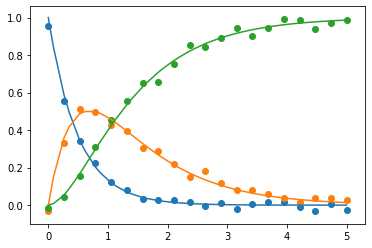

In [10]:
fig, ax = plt.subplots()
ax.plot(list(ms.time), [ms.ca[t]() for t in ms.time])
ax.plot(list(ms.time), [ms.cb[t]() for t in ms.time])
ax.plot(list(ms.time), [ms.cc[t]() for t in ms.time])
ax.scatter(data[0]['ca_meas'].keys(), data[0]['ca_meas'].values())
ax.scatter(data[0]['cb_meas'].keys(), data[0]['cb_meas'].values())
ax.scatter(data[0]['cc_meas'].keys(), data[0]['cc_meas'].values())

In [11]:
nlp = PyomoNLP(m)
parm_vars = [m.k1, m.k2]
Hred = hess.getHred(nlp, parm_vars)

In [15]:
n = len(data[0]['ca_meas']) + len(data[0]['cb_meas']) + len(data[0]['cc_meas'])
p = 2
s2 = m.obj() / (n - p)
print('n:', n, ' p:', p, ' s2:', s2)

n: 60  p: 2  s2: 0.0004503705074266106


In [16]:
cov = 2 * s2 * np.linalg.inv(Hred)
print('Covariance Matrix')
print(cov)

Covariance Matrix
[[ 0.00233427 -0.0003573 ]
 [-0.0003573   0.00031832]]


In [29]:
parm_sd = np.sqrt(np.diag(cov))
conf_mult = np.sqrt(p * spstat.f.ppf(0.95, p, n - p))
print("conf multiplier:", conf_mult)
conf_int = conf_mult * parm_sd
print("confidence interval delta from nominal")
print(conf_int)

conf multiplier: 2.512342321778812
confidence interval delta from nominal
[0.12138211 0.04482384]
